### Импорт необходимых библиотек и настройка графического стиля

In [ ]:
pip install geopy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from geopy.geocoders import Nominatim

In [3]:
mpl.style.use(['Solarize_Light2'])

### Загрузка датасета и его чтение

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [39]:
data = pd.read_csv('data.csv')

### Датафрейм: определение размера и основных характеристик

In [6]:
data.shape

(600000, 14)

В датафрейме 600000 строк и 14 столбцов.

In [7]:
data.describe().round(3)

,Unnamed: 0,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,600000.000,6.000000e+05,600000.000,600000.000,600000.000,600000.000,600000.000,600000.000,600000.000,600000.000,600000.000,600000.000
mean,299999.500,4.389496e+06,54.034,53.303,4312.066,1.951,6.216,11.386,1.725,53.934,10.627,3.938
std,173205.225,2.168699e+07,4.625,20.783,3308.912,1.039,4.957,6.531,1.082,32.647,6.579,4.555
min,0.000,-2.114150e+09,41.459,19.906,3.000,0.000,1.000,1.000,-2.000,0.220,0.030,1.000
25%,149999.750,1.950000e+06,53.376,37.781,2661.000,1.000,2.000,5.000,1.000,38.100,7.000,1.000
50%,299999.500,2.990000e+06,55.170,43.127,2922.000,2.000,5.000,10.000,2.000,48.020,9.700,1.000
75%,449999.250,4.800000e+06,56.226,65.658,6171.000,3.000,9.000,16.000,2.000,63.130,12.700,11.000
max,599999.000,2.083290e+09,71.980,158.696,16705.000,5.000,39.000,39.000,9.000,5985.000,1273.000,11.000


### Пропущенные значения: их количество и процент от общего количества значений. Составление тепловой карты.

In [8]:
table = pd.DataFrame({
    'Type': data.dtypes,
    'NUnique': data.nunique(),
    'Null_quantity': data.isna().sum(),
    'Null_percent': round((data.isnull().sum() / len(data) *100), 3)
})
display(table)

,Type,NUnique,Null_quantity,Null_percent
Unnamed: 0,int64,600000,0,0.0
price,int64,68951,0,0.0
date,object,983,0,0.0
time,object,84808,0,0.0
geo_lat,float64,172906,0,0.0
geo_lon,float64,173152,0,0.0
region,int64,82,0,0.0
building_type,int64,6,0,0.0
level,int64,39,0,0.0
levels,int64,39,0,0.0


Количество пропущенных значений: 0
Процент пропущенных значений: 0.0 %


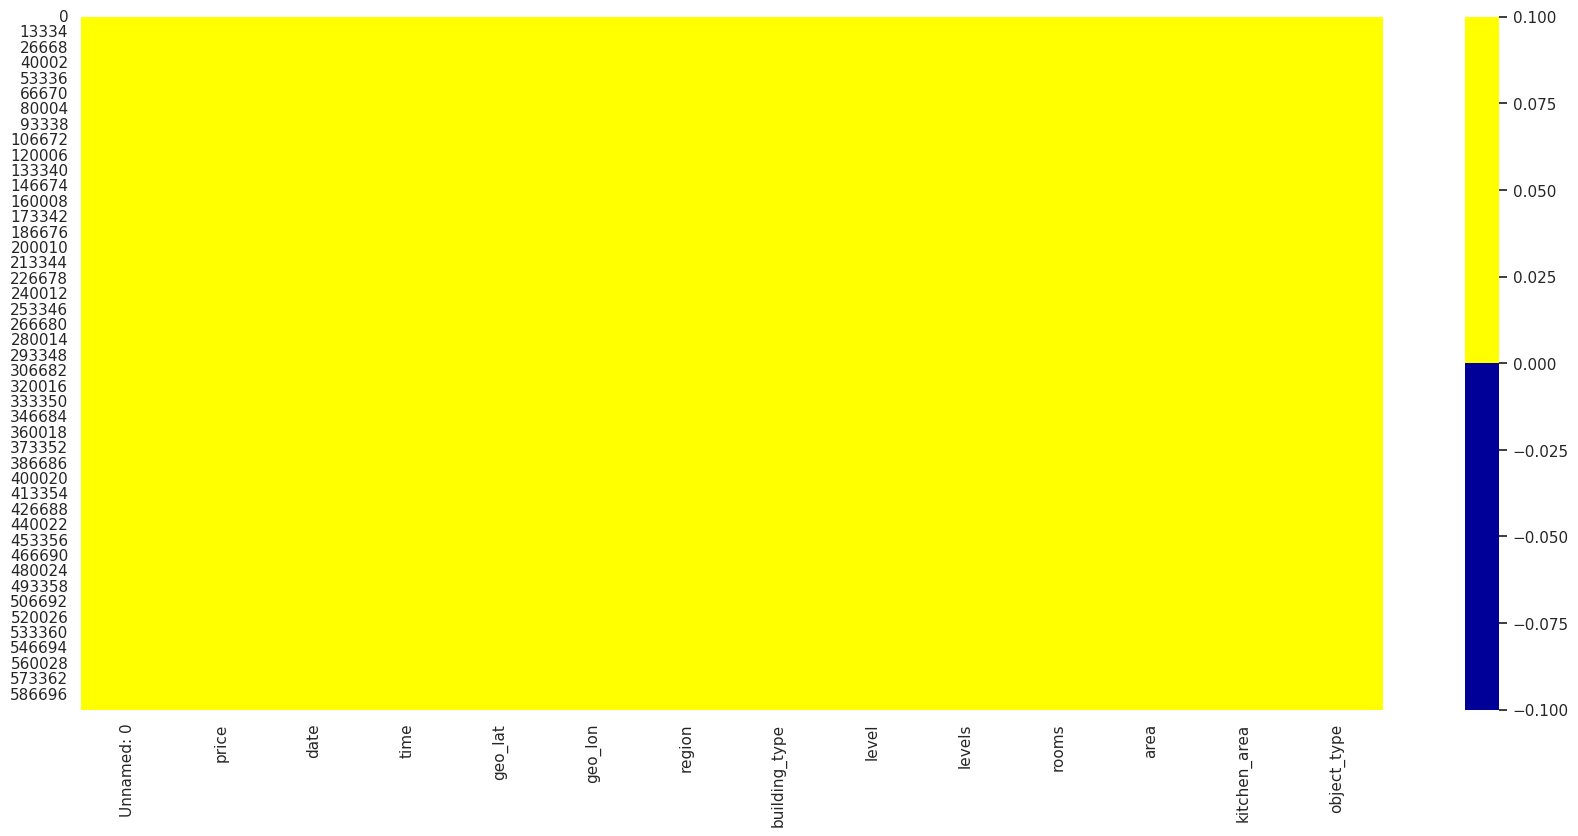

In [9]:
sns.set (rc = {'figure.figsize' : (21,9)})
cols = data.columns
colors = ['#000099', '#ffff00']
sns.heatmap(data[cols].isnull(), cmap = sns.color_palette(colors))
print(f'Количество пропущенных значений: {data.isnull().sum().sum()}')
print(f'Процент пропущенных значений: {round((data.isnull().sum().sum() / data.size) * 100, 3)} %')
#ffff00 - желтый цвет (значение есть), #000099 - синий цвет (значения нет)

### Поиск и удаление дубликатов

In [10]:
data.duplicated().value_counts()

False    600000
dtype: int64

Дубликатов в датасете не обнаружено.

### Типы данных в датафрейме: преобразование

In [53]:
#Перевод поля date из формата object в формат datetime64
data['date'] = pd.to_datetime(data['date'])

### Расшифровка предоставленных координат объектов недвижимости. Создание дополнительных полей.

Библиотека geopy имеет очень сильные ограничения по скорости своей работы, (расшифровка датасета из 600000 строк "в лоб" заняла бы почти 5 суток). Решаю задачу путем поиска в датасете всех наименований регионов России и соответствующих им числовым кодам. Полученный набор "ключей" можно распространить на весь датасет. Код ниже.

In [41]:
#Переименование переменной и группировка данных по региону, вывод полей Широты, Долготы и Кода региона
data = data.groupby('region')[['geo_lat', 'geo_lon', 'region' ]].head(1)

#Задание функции поиска адреса объекта по координатам
def get_address_by_location(latlong, language='ru'):
    app = Nominatim(user_agent='grabylnikov')
    try:
        return app.reverse(latlong, language=language).raw
    except:
        return get_address_by_location(latlong)

In [42]:
#Добавление дополнительного поля ШиротаДолгота, в котором будут объединены данные из полей Широта и Долгота
data['latlong'] = list(zip(data['geo_lat'], data['geo_lon']))

#Создание пустого списка
lst = []

#Создание датафрейма, содержащего адрес объекта
df = pd.DataFrame(lst, columns=['geo_lat', 'geo_lon', 'Регион', 'Город/ПГТ/Село', 'Улица', 'Номер дома'])

In [43]:
#Цикл поиска по геоданным и датасету адресов объектов недвижимости
#Циклу подаются сгруппированные данные по кодам регионов России (их 82)
for i in tqdm(range(len(data))):
    latlong = data.iloc[i]['latlong']
    address = get_address_by_location(latlong)
    element = [data.iloc[i]['geo_lat'],
            data.iloc[i]['geo_lon'],
            address['address']['state'] if 'state' in address['address'] else '',
            address['address']['city'] if 'city' in address['address'] 
            else (address['address']['village'] if 'village' in address['address']\
            else(address['address']['town'] if 'town' in address['address'] else '')),
            address['address']['road'] if 'road' in address['address'] else '',
            address['address']['house_number'] if 'house_number' in address['address'] else '']
    lst.append(element)

100%|██████████| 82/82 [00:42<00:00,  1.95it/s]


In [44]:
#Замена в получившихся данных кода региона на наименование региона
df = pd.DataFrame(lst, columns=['geo_lat', 'geo_lon', 'Регион', 'Город/ПГТ/Село', 'Улица', 'Номер дома'])

#Добавление в датафрейм, содержащий адреса объектов, дополнительного поля ШиротаДолгота, в котором будут объединены данные из полей Широта и Долгота
df['latlong'] = list(zip(df['geo_lat'], df['geo_lon']))

#Объединение двух датасетов в один
data_df = pd.merge(data, df, how = 'inner', on = 'latlong')

#Проверка
data_df.head()

,geo_lat_x,geo_lon_x,region,latlong,geo_lat_y,geo_lon_y,Регион,Город/ПГТ/Село,Улица,Номер дома
0,61.657787,50.831367,4417,"(61.657787, 50.831367)",61.657787,50.831367,Республика Коми,Сыктывкар,Октябрьский проспект,2
1,55.876059,37.388217,81,"(55.8760589, 37.3882166)",55.876059,37.388217,Московская область,Путилково,Сходненская улица,19
2,59.911622,30.284556,2661,"(59.9116217, 30.2845562)",59.911622,30.284556,Санкт-Петербург,Санкт-Петербург,Курляндская улица,18
3,54.524271,52.807177,2922,"(54.524271, 52.807177)",54.524271,52.807177,Татарстан,Бугульма,улица Тухачевского,15
4,43.484765,43.594212,9648,"(43.4847646, 43.5942119)",43.484765,43.594212,Кабардино-Балкария,Нальчик,улица Арманд,43


In [45]:
#Сортировка регионов по возрастанию значения кода (для визуального удобства)
data_df.sort_values('region')

,geo_lat_x,geo_lon_x,region,latlong,geo_lat_y,geo_lon_y,Регион,Город/ПГТ/Село,Улица,Номер дома
6,55.704428,37.766989,3,"(55.704428, 37.766989)",55.704428,37.766989,Москва,Москва,Волгоградский проспект (дублёр),82/37
80,48.804556,132.879747,69,"(48.8045557, 132.8797474)",48.804556,132.879747,Еврейская автономная область,Биробиджан,Парковая улица,12
1,55.876059,37.388217,81,"(55.8760589, 37.3882166)",55.876059,37.388217,Московская область,Путилково,Сходненская улица,19
67,53.323544,34.309142,821,"(53.3235438, 34.3091419)",53.323544,34.309142,Брянская область,Брянск,Коммунальная улица,2
21,56.452237,53.784255,1010,"(56.4522374, 53.7842545)",56.452237,53.784255,Удмуртия,городской округ Сарапул,улица Ленина,59
...,...,...,...,...,...,...,...,...,...,...
42,43.234464,44.735823,13913,"(43.234464, 44.735823)",43.234464,44.735823,Ингушетия,Назрань,Новая улица,16
29,43.043523,44.627729,13919,"(43.0435232, 44.6277287)",43.043523,44.627729,Северная Осетия — Алания,Владикавказ,Весенняя улица,
61,68.889270,33.098741,14368,"(68.8892702, 33.0987412)",68.889270,33.098741,Мурманская область,Мурманск,улица Героев Рыбачьего,48
72,63.799053,74.489071,14880,"(63.7990527, 74.4890715)",63.799053,74.489071,Ямало-Ненецкий автономный округ,городской округ Муравленко,улица Ленина,125


In [46]:
# Теперь, когда видно соответствие кода и наименования региона, можно начать процесс переименования
data = pd.read_csv('data.csv')

# Переименование кода региона в наименование региона
data.loc[data['region'] == 3, 'region' ] = 'Москва'
data.loc[data['region'] == 69, 'region' ] = 'Еврейская автономная область'
data.loc[data['region'] == 81, 'region' ] = 'Московская область'
data.loc[data['region'] == 821, 'region' ] = 'Брянская область'
data.loc[data['region'] == 1010, 'region' ] = 'Удмуртия'
data.loc[data['region'] == 1491, 'region' ] = 'Рязанская область'
data.loc[data['region'] == 2072, 'region' ] = 'Воронежская область'
data.loc[data['region'] == 2328, 'region' ] = 'Калужская область'
data.loc[data['region'] == 2359, 'region' ] = 'Республика Хакасия'
data.loc[data['region'] == 2484, 'region' ] = 'Ханты-Мансийский автономный округ — Югра'
data.loc[data['region'] == 2528, 'region' ] = 'Саратовская область'
data.loc[data['region'] == 2594, 'region' ] = 'Кировская область'
data.loc[data['region'] == 2604, 'region' ] = 'Ярославская область'
data.loc[data['region'] == 2661, 'region' ] = 'Санкт-Петербург'
data.loc[data['region'] == 2722, 'region' ] = 'Башкортостан'
data.loc[data['region'] == 2806, 'region' ] = 'Тамбовская область'
data.loc[data['region'] == 2814, 'region' ] = 'Орловская область'
data.loc[data['region'] == 2843, 'region' ] = 'Краснодарский край'
data.loc[data['region'] == 2860, 'region' ] = 'Кемеровская область'
data.loc[data['region'] == 2871, 'region' ] = 'Нижегородская область'
data.loc[data['region'] == 2880, 'region' ] = 'Тверская область'
data.loc[data['region'] == 2885, 'region' ] = 'Чеченская Республика'
data.loc[data['region'] == 2900, 'region' ] = 'Ставропольский край'
data.loc[data['region'] == 2922, 'region' ] = 'Татарстан'
data.loc[data['region'] == 3019, 'region' ] = 'Чувашия'
data.loc[data['region'] == 3106, 'region' ] = 'Самарская область'
data.loc[data['region'] == 3153, 'region' ] = 'Оренбургская область'
data.loc[data['region'] == 3230, 'region' ] = 'Ростовская область'
data.loc[data['region'] == 3446, 'region' ] = 'Ленинградская область'
data.loc[data['region'] == 3870, 'region' ] = 'Красноярский край'
data.loc[data['region'] == 3991, 'region' ] = 'Тюменская область'
data.loc[data['region'] == 4007, 'region' ] = 'Дагестан'
data.loc[data['region'] == 4086, 'region' ] = 'Хабаровский край'
data.loc[data['region'] == 4189, 'region' ] = 'Костромская область'
data.loc[data['region'] == 4240, 'region' ] = 'Липецкая область'
data.loc[data['region'] == 4249, 'region' ] = 'Ульяновская область'
data.loc[data['region'] == 4374, 'region' ] = 'Вологодская область'
data.loc[data['region'] == 4417, 'region' ] = 'Республика Коми'
data.loc[data['region'] == 4695, 'region' ] = 'Волгоградская область'
data.loc[data['region'] == 4963, 'region' ] = 'Приморский край'
data.loc[data['region'] == 4982, 'region' ] = 'Марий Эл'
data.loc[data['region'] == 5143, 'region' ] = 'Тульская область'
data.loc[data['region'] == 5178, 'region' ] = 'Республика Тыва'
data.loc[data['region'] == 5241, 'region' ] = 'Мордовия'
data.loc[data['region'] == 5282, 'region' ] = 'Челябинская область'
data.loc[data['region'] == 5368, 'region' ] = 'Иркутская область'
data.loc[data['region'] == 5520, 'region' ] = 'Пермский край'
data.loc[data['region'] == 5703, 'region' ] = 'Курганская область'
data.loc[data['region'] == 5736, 'region' ] = 'Новгородская область'
data.loc[data['region'] == 5789, 'region' ] = 'Владимирская область'
data.loc[data['region'] == 5794, 'region' ] = 'Смоленская область'
data.loc[data['region'] == 5952, 'region' ] = 'Белгородская область	'
data.loc[data['region'] == 5993, 'region' ] = 'Пензенская область'
data.loc[data['region'] == 6171, 'region' ] = 'Свердловская область'
data.loc[data['region'] == 6309, 'region' ] = 'Республика Алтай'
data.loc[data['region'] == 6543, 'region' ] = 'Архангельская область'
data.loc[data['region'] == 6817, 'region' ] = 'Алтайский край'
data.loc[data['region'] == 6937, 'region' ] = 'Республика Крым'
data.loc[data['region'] == 7121, 'region' ] = 'Курская область'
data.loc[data['region'] == 7793, 'region' ] = 'Псковская область'
data.loc[data['region'] == 7873, 'region' ] = 'Крым'
data.loc[data['region'] == 7896, 'region' ] = 'Калининградская область'
data.loc[data['region'] == 7929, 'region' ] = 'Амурская область'
data.loc[data['region'] == 8090, 'region' ] = 'Республика Карелия'
data.loc[data['region'] == 8509, 'region' ] = 'Калмыкия'
data.loc[data['region'] == 8640, 'region' ] = 'Омская область'
data.loc[data['region'] == 8894, 'region' ] = 'Ивановская область'
data.loc[data['region'] == 9579, 'region' ] = 'Республика Бурятия'
data.loc[data['region'] == 9648, 'region' ] = 'Кабардино-Балкария'
data.loc[data['region'] == 9654, 'region' ] = 'Новосибирская область'
data.loc[data['region'] == 10160, 'region' ] = 'Забайкальский край'
data.loc[data['region'] == 10201, 'region' ] = 'Томская область'
data.loc[data['region'] == 10582, 'region' ] = 'Астраханская область'
data.loc[data['region'] == 11171, 'region' ] = 'Республика Саха (Якутия)'
data.loc[data['region'] == 11416, 'region' ] = 'Адыгея'
data.loc[data['region'] == 11991, 'region' ] = 'Карачаево-Черкесия'
data.loc[data['region'] == 13098, 'region' ] = 'Камчатский край'
data.loc[data['region'] == 13913, 'region' ] = 'Ингушетия'
data.loc[data['region'] == 13919, 'region' ] = 'Северная Осетия — Алания'
data.loc[data['region'] == 14368, 'region' ] = 'Мурманская область'
data.loc[data['region'] == 14880, 'region' ] = 'Ямало-Ненецкий автономный округ'
data.loc[data['region'] == 16705, 'region' ] = 'Магаданская область'

In [47]:
#Расчет дополнительного поля - цены за квадратный метр для конкретного объекта. 
#Исхожу из того. что значение в поле kitchen_area является частью поля area, и складывать их не нужно
data['price_per_meter'] = round(data['price'] / data['area'], 2)

### График сезонности в динамике количества опубликованных объявлений.

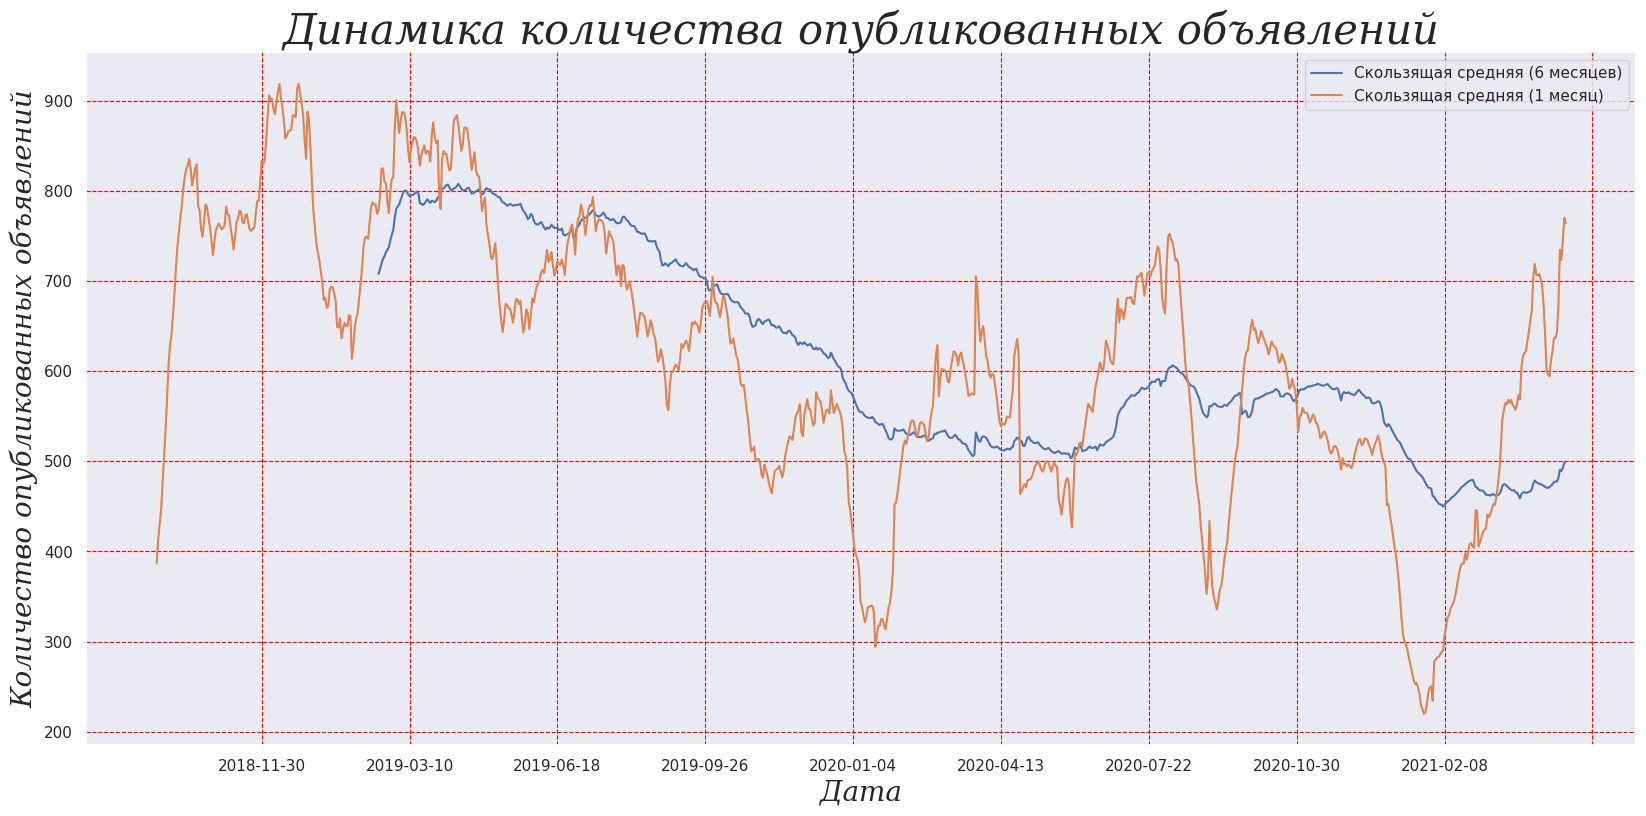

In [19]:
plt.figure(figsize = (20,9))
ads = data.groupby('date').count()['region']
ads.rolling(180).mean().plot(label = 'Скользящая средняя (6 месяцев)')
ads.rolling(30).mean().plot(label = 'Скользящая средняя (1 месяц)')
plt.title('Динамика количества опубликованных объявлений', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Дата', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Количество опубликованных объявлений', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
#plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

Сезонность по количеству заявок присутствует на всем временном отрезке. Рост количества заявок стабильно наблюдается в март-апрель (3-4), июль(7), сентябрь(9) и декабрь(12). Снижение количества происходит в феврале(2), июне(6), августе (8) и ноябре (11). Также на данных с приходом COVID-19 сезонность сохраняется, но колебания количества увеличиваются более чем двукратно - с 200 до 400-500.

### Логические ошибки и опечатки

Проверка датасета на отрицательные значения.

In [20]:
data.loc[(data['price'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,
Краснодарский край,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Нижегородская область,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Новосибирская область,36,36,36,36,36,36,36,36,36,36,36,36,36,36
Санкт-Петербург,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Татарстан,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Тюменская область,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
data.loc[(data['rooms'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,
Адыгея,23,23,23,23,23,23,23,23,23,23,23,23,23,23
Алтайский край,250,250,250,250,250,250,250,250,250,250,250,250,250,250
Амурская область,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Архангельская область,16,16,16,16,16,16,16,16,16,16,16,16,16,16
Астраханская область,3,3,3,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ханты-Мансийский автономный округ — Югра,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Челябинская область,422,422,422,422,422,422,422,422,422,422,422,422,422,422
Чеченская Республика,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [22]:
table = pd.DataFrame({
    'price_less_than_zero': [len(data.loc[(data['price'] < 0)])],
    'rooms_less_than_zero': [len(data.loc[(data['rooms'] < 0)])]
})
display(table)

,price_less_than_zero,rooms_less_than_zero
0,44,33543


Отрицательные значения найдены в полях price и rooms. Известно, что значение -1 в поле rooms означает квартиру-студию

Допускаю, что ошибка -2 в поле rooms - это опечатка, поэтому: -2 исправляю на 2

In [48]:
data.loc[data['rooms'] == -2, 'rooms'] = 2

Выявление объектов с явно нереалистичной ценой за квадратный метр (либо слишком малой, либо слишком большой)

In [49]:
Q_01 = data['price_per_meter'].quantile(0.01) # 1% граница нижнего ценового диапазона за кв.м
Q_99 = data['price_per_meter'].quantile(0.99) # 99% граница верхнего ценового диапазона за кв.м
data_err = data[(data['price_per_meter'] < Q_01 ) | (data['price_per_meter'] > Q_99)]
print(f'1% граница нижнего ценового диапазона за кв.м: {Q_01} рублей')
print(f'99% граница верхнего ценового диапазона за кв.м: {Q_99} рублей')
print(f'Всего объектов с явно нереалистичной ценой: {len(data_err)}')

1% граница нижнего ценового диапазона за кв.м: 18000.0 рублей
99% граница верхнего ценового диапазона за кв.м: 305588.4800000002 рублей
Всего объектов с явно нереалистичной ценой: 11985


Считаю. что информация в этих строках указана с ошибкой, поэтому удаляю строки из датасета

In [50]:
data = data[(data['price_per_meter'] > Q_01 ) & (data['price_per_meter'] < Q_99)]

### Описательный портрет самой дорогой квартиры

С помощью 97.5 процентиля отбираю значения цены для high end сегмента недвижимости и их медиану

In [27]:
high_end_segm = data['price'].quantile(q=0.975)
data[(data['price'] > high_end_segm)].sort_values('price')

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
352449,352449,13950500,2020-02-01,11:14:33,45.023284,38.958793,Краснодарский край,0,13,22,3,148.50,27.60,1,93942.76
537651,537651,13951861,2020-12-30,23:30:44,55.753960,37.620393,Москва,2,22,26,3,76.40,17.70,11,182615.98
7711,7711,13952000,2018-09-18,00:27:50,59.981231,30.354002,Санкт-Петербург,3,4,10,3,87.20,33.08,1,160000.00
28316,28316,13953999,2018-10-12,15:06:05,55.850909,37.617527,Москва,2,7,11,3,84.93,14.89,11,164300.00
375525,375525,13954759,2020-03-11,21:32:07,59.896246,30.309932,Санкт-Петербург,2,14,19,3,106.10,22.10,11,131524.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440095,440095,97000000,2020-07-03,09:12:04,43.585455,39.723155,Краснодарский край,2,5,7,5,361.00,46.00,1,268698.06
524877,524877,98991000,2020-12-01,19:13:27,59.994430,30.197023,Санкт-Петербург,2,22,24,4,340.00,20.00,1,291150.00
523790,523790,99500000,2020-11-30,20:43:15,56.327966,44.010770,Нижегородская область,0,9,10,5,360.00,53.00,1,276388.89
64502,64502,109500000,2018-11-28,14:31:27,59.962803,30.267478,Санкт-Петербург,2,10,11,5,384.00,100.00,11,285156.25


In [28]:
data[(data['price'] > high_end_segm)].agg({'price': 'median',
                                          'level': 'median',
                                          'levels': 'median',
                                          'rooms': 'median',
                                          'building_type': 'median',
                                          'area': 'median',
                                          'kitchen_area': 'median',
                                          'price_per_meter': 'median',
                                          'object_type': 'median'}).to_frame()

,0
price,17718867.00
level,6.00
levels,14.00
rooms,3.00
building_type,2.00
area,94.40
kitchen_area,16.30
price_per_meter,205862.63
object_type,1.00


Описательный портрет дорогой квартиры. Это 3-комнатная квартира вторичного рынка недвижимости в 14-этажном монолитном здании, расположенная на 6 этаже площадью 95 квадратных метров и кухней 16 квадратных метров, стоимость которой примерно равна 17.7 млн рублей. Цена за квадратный метр 206 тысяч

### Описательный портрет самой дешевой квартиры

При составлении описательного портрета дешевых квартир, под квартирой подразумеваю площадь отдельного помещения не менее 18 квадратных метров (социальные нормы России). Поэтому вношу изменения в датасет, что именно считать квартирой

In [29]:
data = data[(data['area'] >= 18)]

С помощью 2,5 процентиля отбираю значения цены для low end сегмента недвижимости и их медиану

In [30]:
low_end_segm = data['price'].quantile(q=0.025)
data[(data['price'] < low_end_segm)]

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
8,8,1000000,2018-07-03,15:35:00,45.102882,38.637617,Краснодарский край,1,2,3,1,40.00,12.00,1,25000.00
50,50,975000,2018-09-08,01:34:56,55.013916,83.003290,Новосибирская область,1,10,10,1,39.00,1.00,11,25000.00
62,62,1000000,2018-09-08,01:40:05,54.943610,82.962845,Новосибирская область,1,3,10,1,33.00,5.00,11,30303.03
99,99,963000,2018-09-08,01:54:26,54.947141,82.958596,Новосибирская область,1,1,10,1,32.12,4.00,11,29981.32
119,119,1003000,2018-09-08,02:07:40,55.013916,83.003290,Новосибирская область,1,6,10,1,39.35,4.39,11,25489.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599120,599120,950000,2021-05-01,08:18:30,57.160061,60.575353,Свердловская область,0,1,2,1,28.60,6.00,1,33216.78
599167,599167,1000000,2021-05-01,08:47:12,58.095512,38.736895,Ярославская область,3,1,3,2,43.00,6.00,1,23255.81
599421,599421,945000,2021-05-01,10:48:50,53.347860,58.979240,Челябинская область,1,8,10,-1,26.00,5.00,11,36346.15
599533,599533,550000,2021-05-01,12:44:51,57.743755,40.995876,Костромская область,3,5,5,1,18.00,7.00,1,30555.56


In [31]:
data[(data['price'] < low_end_segm)].agg({'price': 'median',
                                         'level': 'median',
                                         'levels': 'median',
                                         'rooms': 'median',
                                         'building_type': 'median',
                                         'area': 'median',
                                         'kitchen_area': 'median',
                                         'price_per_meter': 'median',
                                          'object_type': 'median'}).to_frame()

,0
price,910000.00
level,3.00
levels,5.00
rooms,1.00
building_type,3.00
area,32.47
kitchen_area,6.00
price_per_meter,28011.20
object_type,1.00


Описательный портрет дешевой квартиры. Это 1-комнатная квартира вторичного рынка недвижимости в 5-этажном кирпичном здании, расположенная на 3 этаже площадью 32 квадратных метра и 6 метровой кухней, стоимостью у которой в районе 910 тысяч рублей. Цена за квадратный метр 28 тысяч рублей. Классическая советская хрущевка конца 60-х.

### Поведение цен на недвижимость в динамике

In [ ]:
#Определение скользящей средней цены квадратного метра недвижимости

In [54]:
data.dtypes

Unnamed: 0                  int64
price                       int64
date               datetime64[ns]
time                       object
geo_lat                   float64
geo_lon                   float64
region                     object
building_type               int64
level                       int64
levels                      int64
rooms                       int64
area                      float64
kitchen_area              float64
object_type                 int64
price_per_meter           float64
dtype: object

In [55]:
data.head(1)

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
0,0,2370000,2018-04-09,15:55:58,61.657787,50.831367,Республика Коми,1,5,5,2,47.0,6.0,1,50425.53


In [56]:
data.set_index('date', inplace = True)

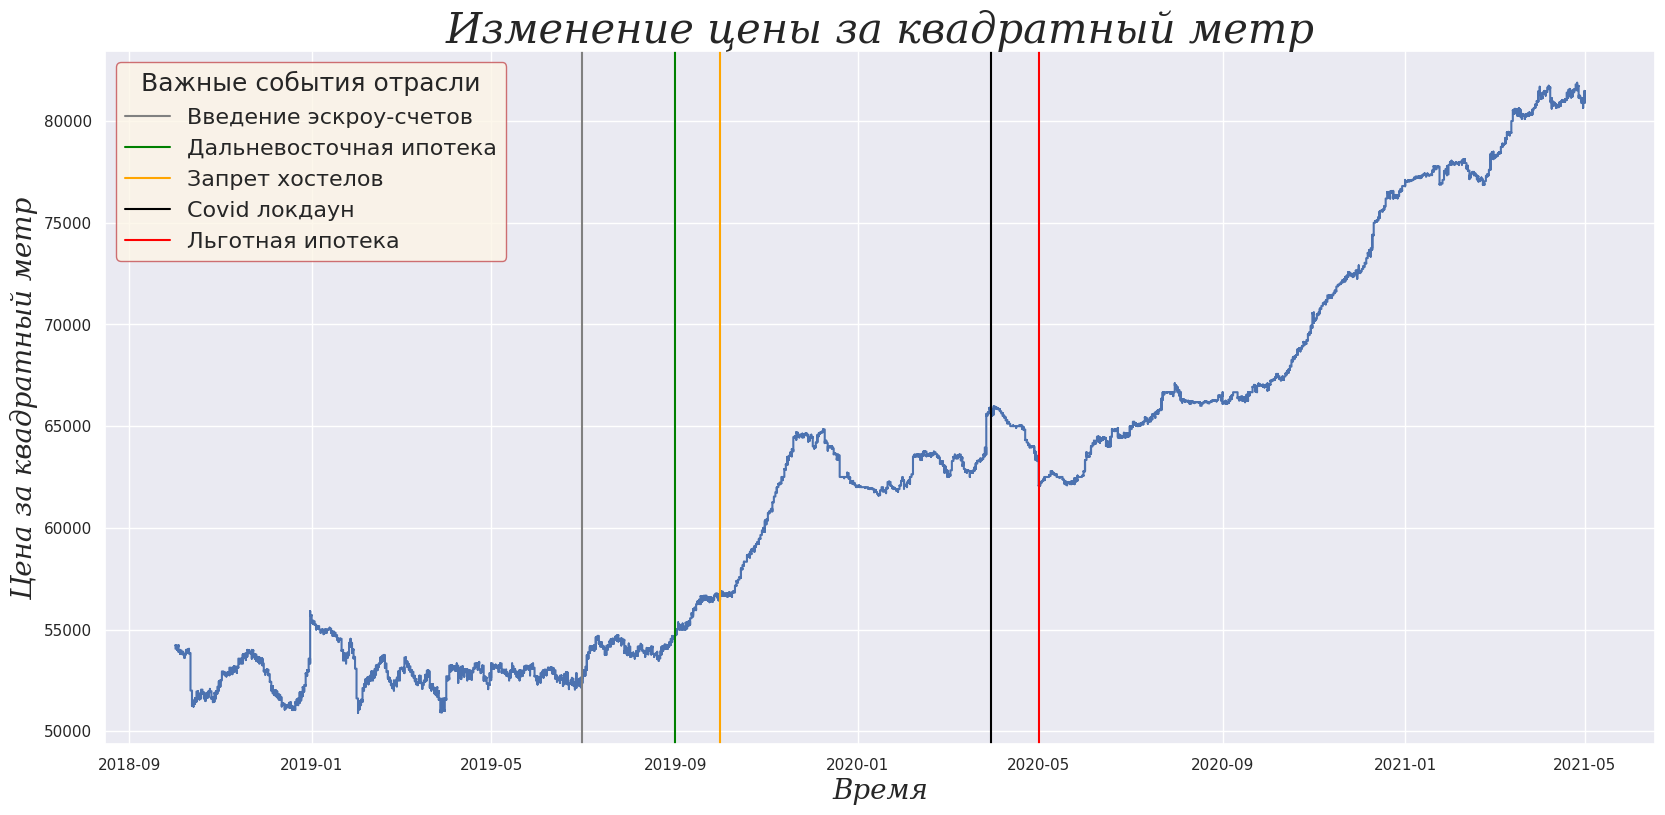

In [57]:
plt.figure(figsize = (20,9))
plt.plot(data['price_per_meter'].rolling(20000).median())
plt.title('Изменение цены за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Время', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.axvline (x=mpl.dates.datestr2num('2019-07-01'), color = 'grey', label = 'Введение эскроу-счетов')
plt.axvline (x=mpl.dates.datestr2num('2019-09-01'), color = 'green', label = 'Дальневосточная ипотека')
plt.axvline (x=mpl.dates.datestr2num('2019-10-01'), color = 'orange', label = 'Запрет хостелов')
plt.axvline (x=mpl.dates.datestr2num('2020-03-30'), color = 'black', label = 'Covid локдаун')
plt.axvline (x=mpl.dates.datestr2num('2020-05-01'), color = 'red', label = 'Льготная ипотека')
plt.minorticks_on()
#plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
#plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend(fontsize = 16,
          ncol = 1, #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title = 'Важные события отрасли',    #  заголовок
          title_fontsize = '18'    #  размер шрифта заголовка
         )
plt.show()

In [58]:
# Цена за квадратный метр для вторичного рынка недвижимости
old = data.loc[(data['object_type'] == 1)]['price_per_meter']

# Цена за квадратный метр для новостроек
new = data.loc[(data['object_type'] == 11)]['price_per_meter']

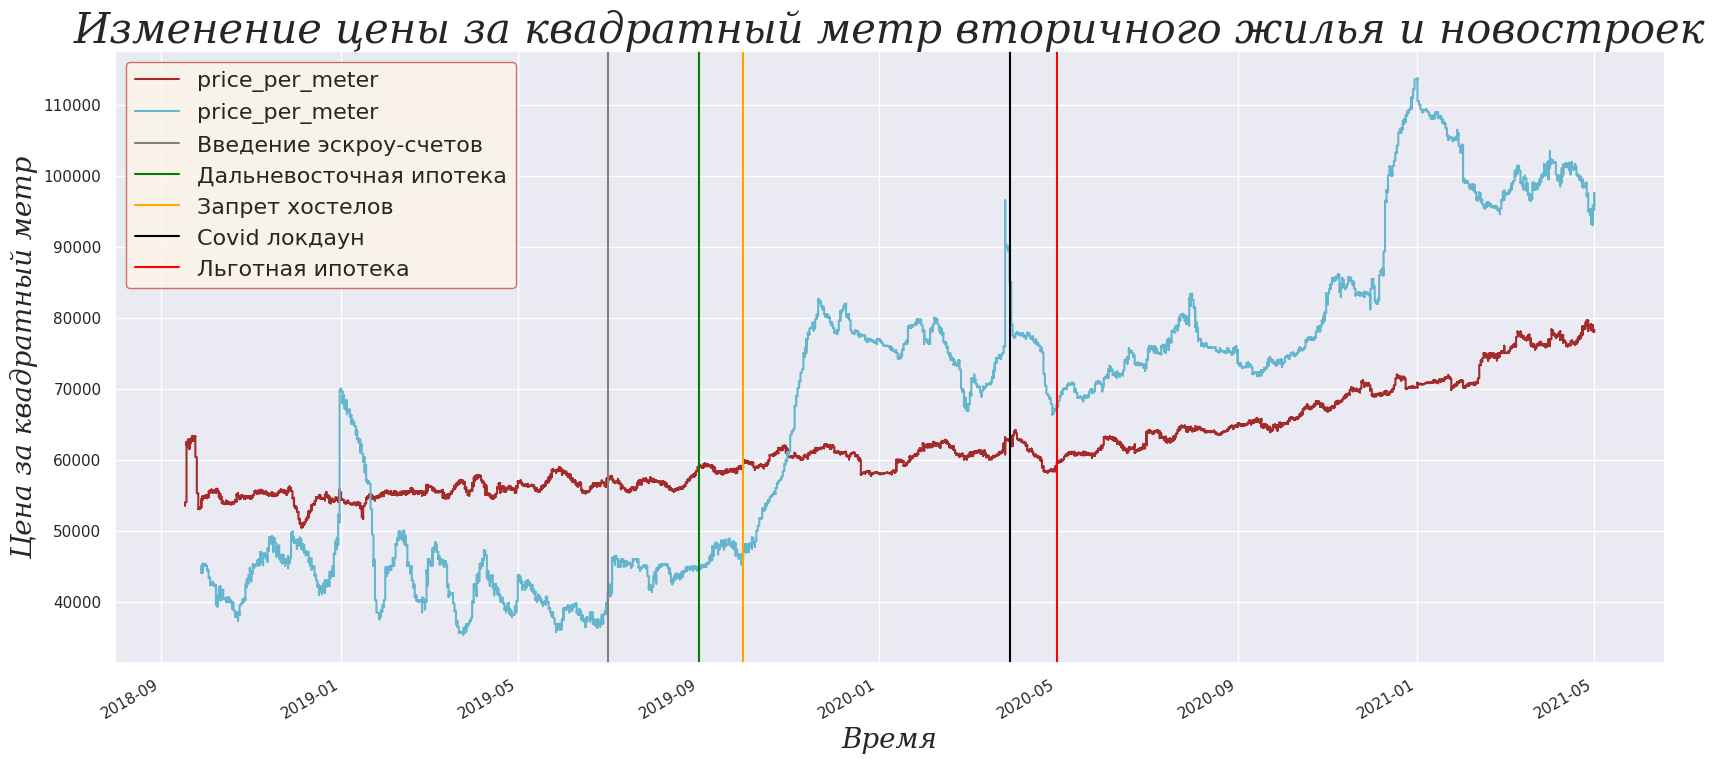

In [59]:
plt.figure(figsize = (20,9))
old.rolling(5000).median().plot(color = 'brown') # Вторичное жилье
new.rolling(5000).median().plot(color = 'c')     # Новостройки
plt.title('Изменение цены за квадратный метр вторичного жилья и новостроек', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Время', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.axvline (x=mpl.dates.datestr2num('2019-07-01'), color = 'grey', label = 'Введение эскроу-счетов')
plt.axvline (x=mpl.dates.datestr2num('2019-09-01'), color = 'green', label = 'Дальневосточная ипотека')
plt.axvline (x=mpl.dates.datestr2num('2019-10-01'), color = 'orange', label = 'Запрет хостелов')
plt.axvline (x=mpl.dates.datestr2num('2020-03-30'), color = 'black', label = 'Covid локдаун')
plt.axvline (x=mpl.dates.datestr2num('2020-05-01'), color = 'red', label = 'Льготная ипотека')
plt.minorticks_on()
#plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
#plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend(fontsize = 16,
          ncol = 1, #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          #title = 'Важные события отрасли',    #  заголовок
          title_fontsize = '18'    #  размер шрифта заголовка
         )
plt.show()

**Цена квадратного метра по стране растет, на что повлияли следующие события**

**События 2019**
1 июля - переход на эскроу-счета, застройщик до окончания строительства не может пользоваться деньгами дольщиков. Следствие - консолидация рынка в руках крыпных игроков, имеющих больше оборотных автивов, и уход малых.

1 сентября - запуск Дальневосточной специальной ипотечной программы со ставкой 2%.

1 октября - запрет хостелов с жилых помещениях. Оказывает поддержку ценам за квадратный метр. Стоимость квартир в домах, где появляется хостел, снижается на треть.

21 ноября - Ввод в эксплуатацию МЦД-1, МЦД-2 для Москвы и Московской области - рост цен на жилье вблизи диаметров - от 10 до 40%.


**События 2020**

Ковид - снижение объема строительства на 30% весной и антикризисные меры правительства.

Весна - Введение льготной ипотеки под 6,5% годовых на новостройки. Благодаря этой программе в России уже к ноябрю был установлен годовой рекорд выдачи жилищных кредитов — 3,2 трлн руб. Однако ажиотажный спрос на льготную ипотеку привел к значительному повышению цен на новостройки и вторичное жилье.

Программа субсидирования кредитов застройщикам, чтобы средства максимально вкладывались в стройку, а не погашение кредитов.

**События 2021**

Продолжение роста цен на недвижимость из-за программы льготной ипотеки.

Новый годовой рекорд выдачи жилищных кредитов — 5 трлн руб

Рост себестоимости строительства из-за подорожания стройматериалов, разрыва цепочек поставок по всему миру и нехватки рабочих рук на стройках, что также увеличивает цену квадратного метра.

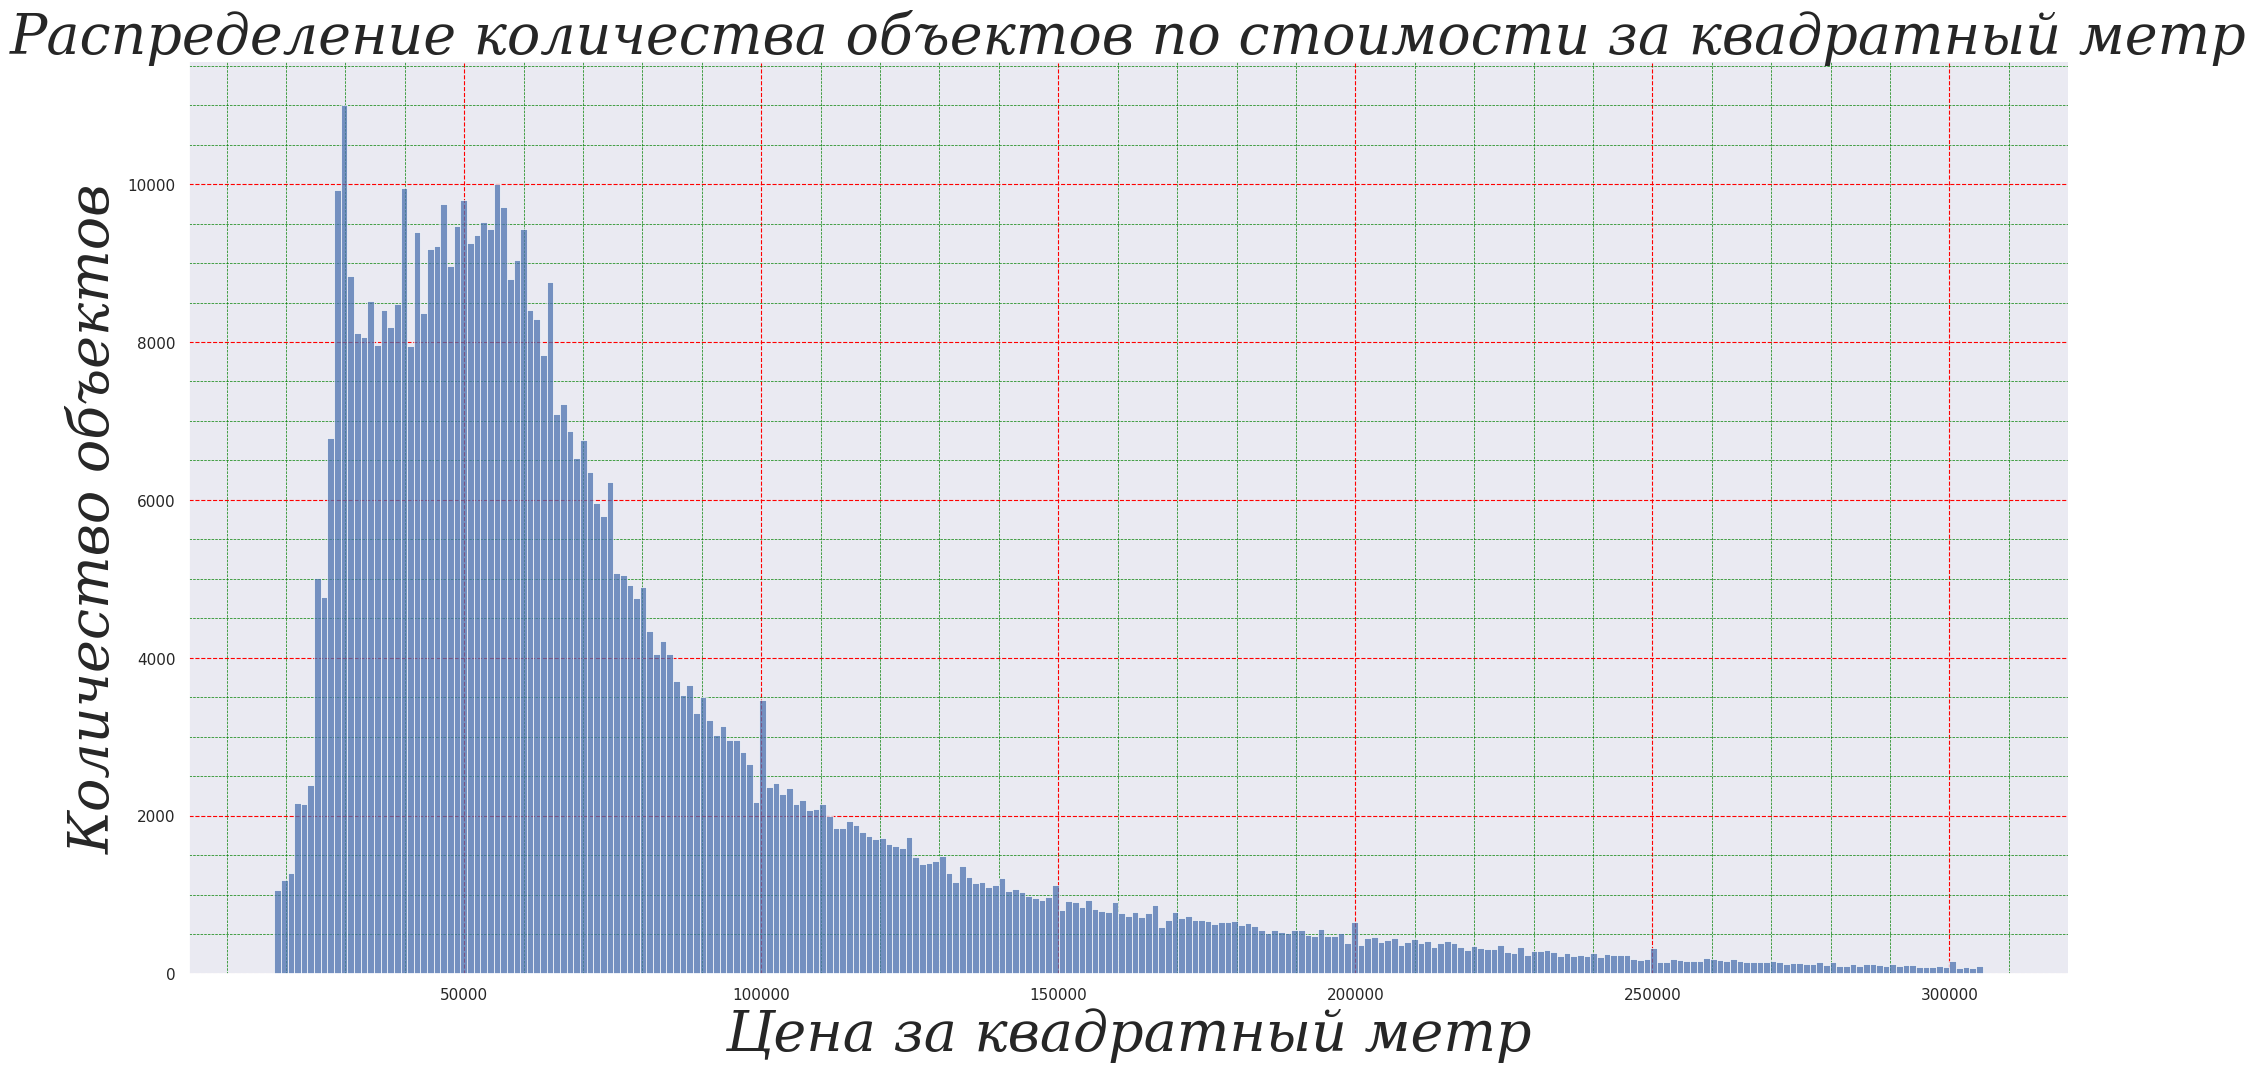

In [60]:
sns.displot(data['price_per_meter'], height= 10 , aspect= 2)
plt.title('Распределение количества объектов по стоимости за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.xlabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.ylabel('Количество объектов', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
#plt.legend()
plt.show()

### Рост и падение рынка недвижимости: анализ по регионам России

In [61]:
#Сброс индекса с поля date
data.reset_index(inplace= True )

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


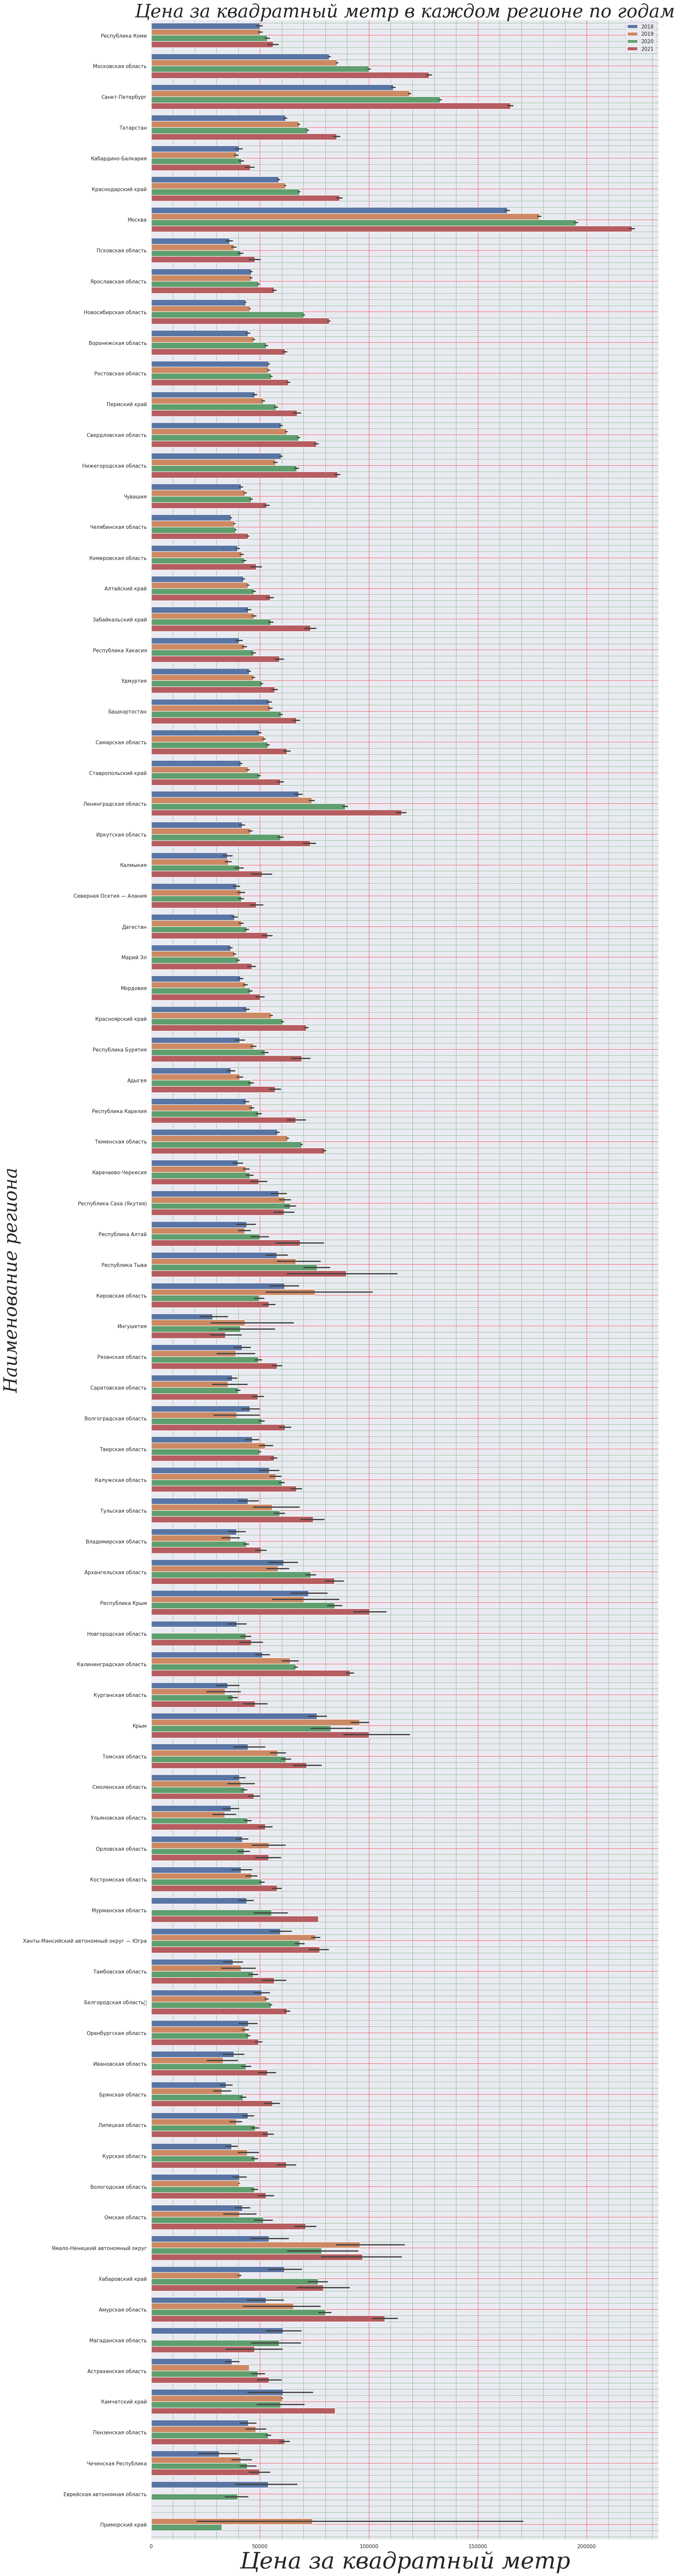

In [62]:
plt.figure(figsize = (20,100))
sns.barplot(data=data, x='price_per_meter', y='region', hue=data['date'].dt.year)
plt.title('Цена за квадратный метр в каждом регионе по годам', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.xlabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 50)
plt.ylabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

Снижение стоимости квадратного метра зафиксировано в Кировской, Еврейской, Магаданской, Ямало-Ненецкой областях, в Ингушетии и Приморском крае. Рост выше, чем в целом по стране зафиксирован в Москве и Московской области, Санкт-Петербурге и Ленинградской области, Краснодарском крае, Новосибирской и Амурской областях. Основной вклад в рост квадратного метра недвижимости вносит 2021 год. В большинстве регионов с 2018 по 2020 рост либо отсутствовал, либо находился на уровне 5%.  #Добавить проценты роста

### Рекомендации по инвестированию в объекты недвижимости

Рассматриваю данные на примере Ярославской области, где сейчас живу

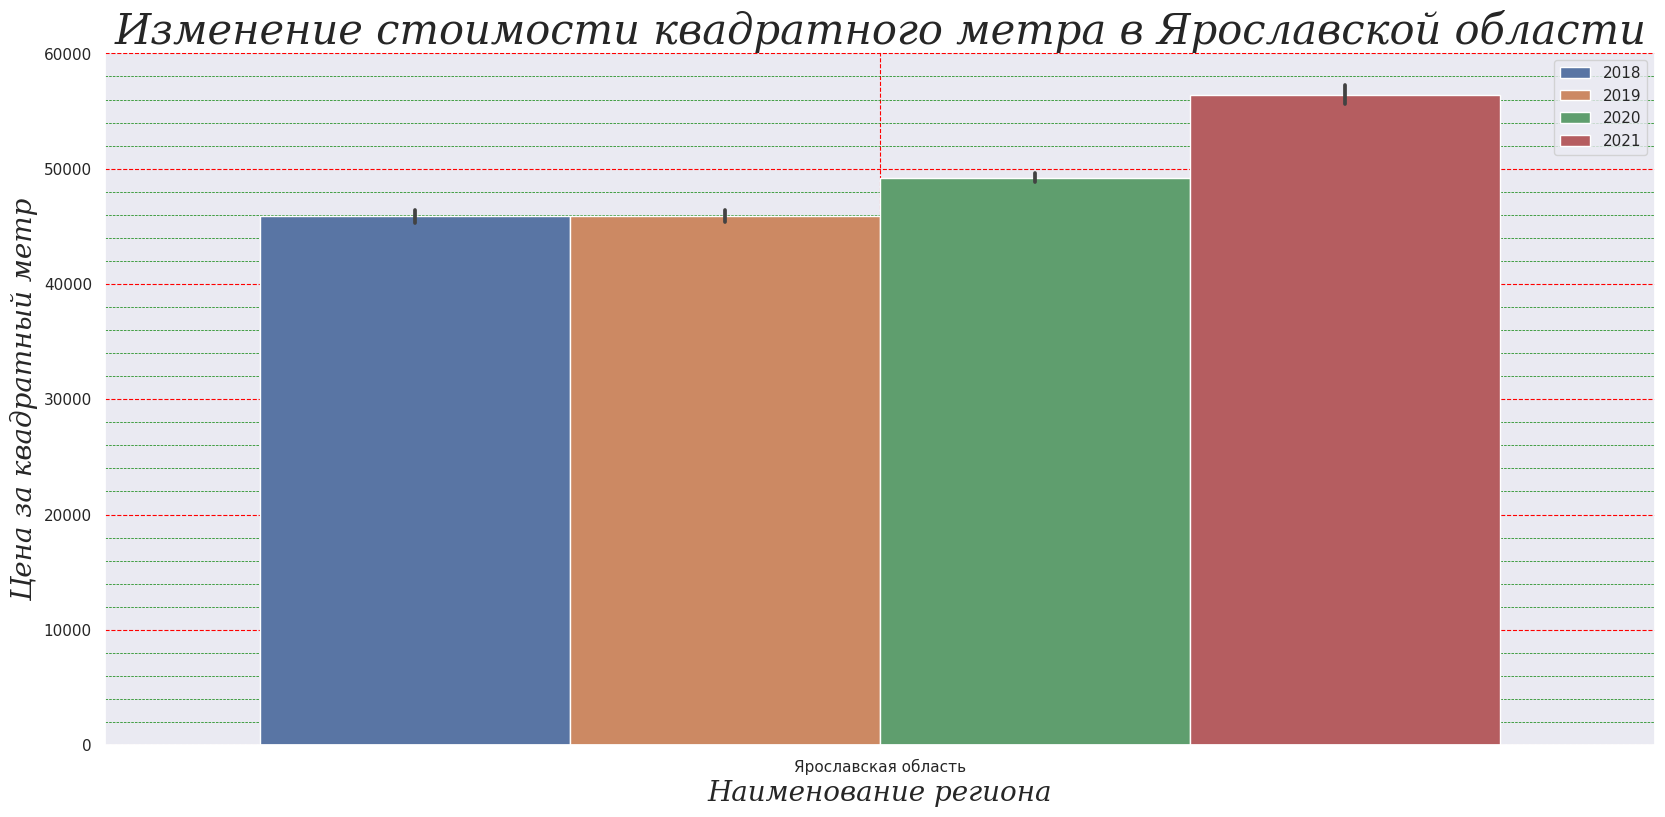

In [63]:
data_yar = data.loc[data['region'] == 'Ярославская область']

plt.figure(figsize = (20,9))
sns.barplot(data=data_yar, y='price_per_meter', x='region', hue=data['date'].dt.year)
plt.title('Изменение стоимости квадратного метра в Ярославской области', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

В 2017 году летом для сохранения сбережений и последующей сдачи недвижимости в долгосрочную аренду инвестировал в покупку 4 квартир. Выбрал классические советские 1-комнатные хрущевки в 5-этажных зданиях из красного кирпича, этажи с 3 по 5, в спальном районе, но в 2-3 минутах от остановки общественного транспорта. Причины: 1-комнатные квартиры наиболее востребованы потенциальными арендаторами (может снимать как семья, так и пара или один человек). Причем время показало, что даже введенная государством программа льготной ипотеки не влияет на спрос 1-комнатных квартир. Снимая 1-комнатную квартиру, люди параллельно копят на первый взнос по ипотеке. Доходность относительно цены квадратного метра составляет 7,5-8% годовых. И она больше, чем при сдаче 2-комнатной квартиры. К дополнительной доходности можно отнести и рост стоимости квадратного метра за последние 5 лет. Коммуникации в зданиях этого типа до сих пор обладают приличным запасом надежности. Вероятность ремонта у соседей ниже, чем в новостройках. Условия слышимости в сравнении с теми же новостройками - лучше. В здании этого проекта нет лифтов, что также снижает уровень шума